In [107]:
import sys
sys.path.append('../')  

from custom_loss_functions import psnr

from tensorflow.keras.models import load_model
from hformer_model import get_hformer_model, PatchExtractor

from skimage.util import view_as_blocks

import numpy as np

from skimage.metrics import peak_signal_noise_ratio

import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras import backend as K

from sklearn.model_selection import train_test_split

from data_importer import load_testing_images
from data_importer import load_training_images

In [3]:
# Get model and build (required for loading weights).

model = get_hformer_model(num_channels_to_be_generated=16, name="hformer_model")
model.build(input_shape=(None, 64, 64, 1)) 

In [124]:
model.summary()

Model: "hformer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_projection_layer (Inp  multiple                 160       
 utProjectionLayer)                                              
                                                                 
 output_projection_layer (Ou  multiple                 145       
 tputProjectionLayer)                                            
                                                                 
 conv_net_block_1 (Convoluti  multiple                 1376      
 onBlock)                                                        
                                                                 
 conv_net_block_2 (Convoluti  multiple                 1376      
 onBlock)                                                        
                                                                 
 downsampling_layer_1 (Conv2  multiple               

In [4]:
# We are required to set custom_objects since we are using custom loss function
loaded_model = model.load_weights('hformer_25_epoch_16_channel_full_dataset.h5')
history = np.load('hformer_25_epoch_16_channel_full_datasethistory.npy', allow_pickle=True).item()

history keys :  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


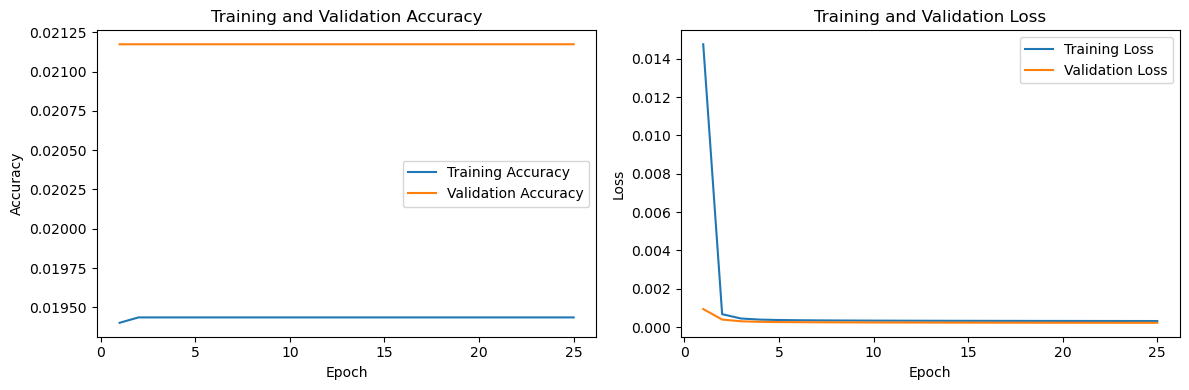

In [5]:
# Visualize model history.
print('history keys : ', history.keys())

# Plot loss, accuracy, val_loss and val_accuracy
import matplotlib.pyplot as plt

# Get the number of epochs
num_epochs = len(history['accuracy'])

# Plot training and validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), history['accuracy'], label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), history['loss'], label='Training Loss')
plt.plot(range(1, num_epochs + 1), history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [109]:
noisy_images, ground_truth_images = load_training_images('../../../../../Dataset/LowDoseCTGrandChallenge/Training_Image_Data', load_limited_images=True, num_images_to_load=10)

patch_extractor = PatchExtractor(patch_size=64, stride=64, name="patch_extractor")
test_image_patches = patch_extractor(noisy_images)

predictions = model.predict(test_image_patches)

loaded training images x and y of len :  10 10  respectively
type of train images x :  float64
range of values in train images :  0.0 0.8802685565087653
type of train images y :  float64
20/20 [==============================] - 2s 49ms/step


In [110]:
def reconstruct_image_from_patches(patches, num_patches_per_row):
    patch_size = patches.shape[1]  # Assuming square patches
    num_patches = patches.shape[0]

    # Calculate the number of rows
    num_patches_per_col = num_patches // num_patches_per_row

    # Initialize an empty image to store the reconstructed result
    reconstructed_image = np.zeros((num_patches_per_col * patch_size, num_patches_per_row * patch_size))

    # Reshape the patches into a 2D array
    patches_2d = patches.reshape((num_patches_per_col, num_patches_per_row, patch_size, patch_size))

    # Reconstruct the image by placing each patch in its corresponding position
    for i in range(num_patches_per_col):
        for j in range(num_patches_per_row):
            reconstructed_image[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size] = patches_2d[i, j]

    return np.expand_dims(reconstructed_image, axis=-1)



In [111]:
def calculate_psnr(original_image, reconstructed_image):
    psnr_value = peak_signal_noise_ratio(original_image, reconstructed_image)
    return psnr_value


In [122]:
def visualize_patches(patches, noisy_images,  ground_truth_images, num_images):
    num_patches_per_image = int(patches.shape[0] / num_images)

    print('patches per image : ', num_patches_per_image)

    for i in range(num_images):
        print('this image has start patches : ', i * num_patches_per_image)
        image_patches = patches[i * num_patches_per_image:i * num_patches_per_image + num_patches_per_image]

        fig, axes = plt.subplots(1, 4, figsize=(24, 24))
        axes = axes.flatten()
        
        reconstruct_image = reconstruct_image_from_patches(image_patches, 8)
        print('reconstruct_image shape : ', reconstruct_image.shape)
        print('noisy image shape : ', noisy_images[i].shape)
        
        axes[0].set_title('input image')
        axes[0].imshow(noisy_images[i], cmap='gray')
        axes[0].axis('off')
        
        axes[1].set_title('ground truth image')
        axes[1].imshow(ground_truth_images[i], cmap='gray')
        axes[1].axis('off')
        
        
        axes[2].set_title('model prediction')
        axes[2].imshow(reconstruct_image, cmap='gray')
        axes[2].axis('off')
        
        axes[3].set_title('removed noise')
        axes[3].imshow((noisy_images[i] - reconstruct_image), cmap='gray')
        axes[3].axis('off')
        
        print('PSNR of reconsturcted image : ', calculate_psnr(ground_truth_images[i], reconstruct_image))
        print('PSNR of noisy image : ', calculate_psnr(ground_truth_images[i], noisy_images[i]))

        plt.show()


patches per image :  64
this image has start patches :  0
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (512, 512, 1)
PSNR of reconsturcted image :  37.36795529672999
PSNR of noisy image :  35.600297920932945


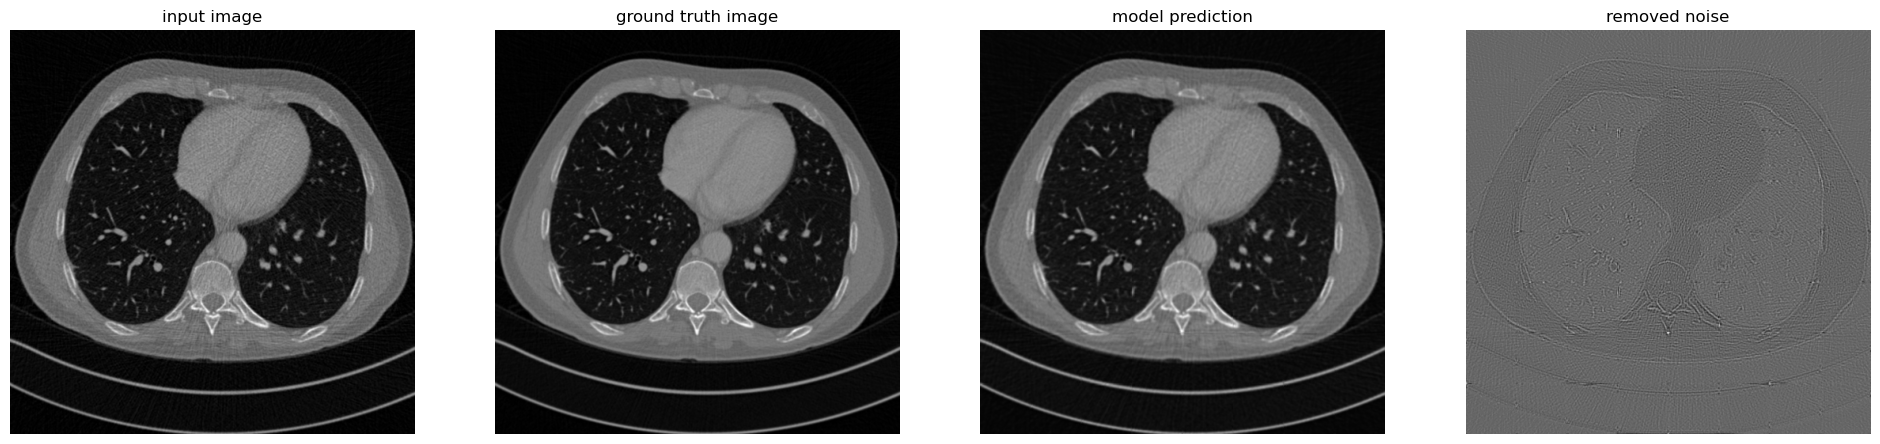

this image has start patches :  64
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (512, 512, 1)
PSNR of reconsturcted image :  37.55374112813005
PSNR of noisy image :  35.84850443503983


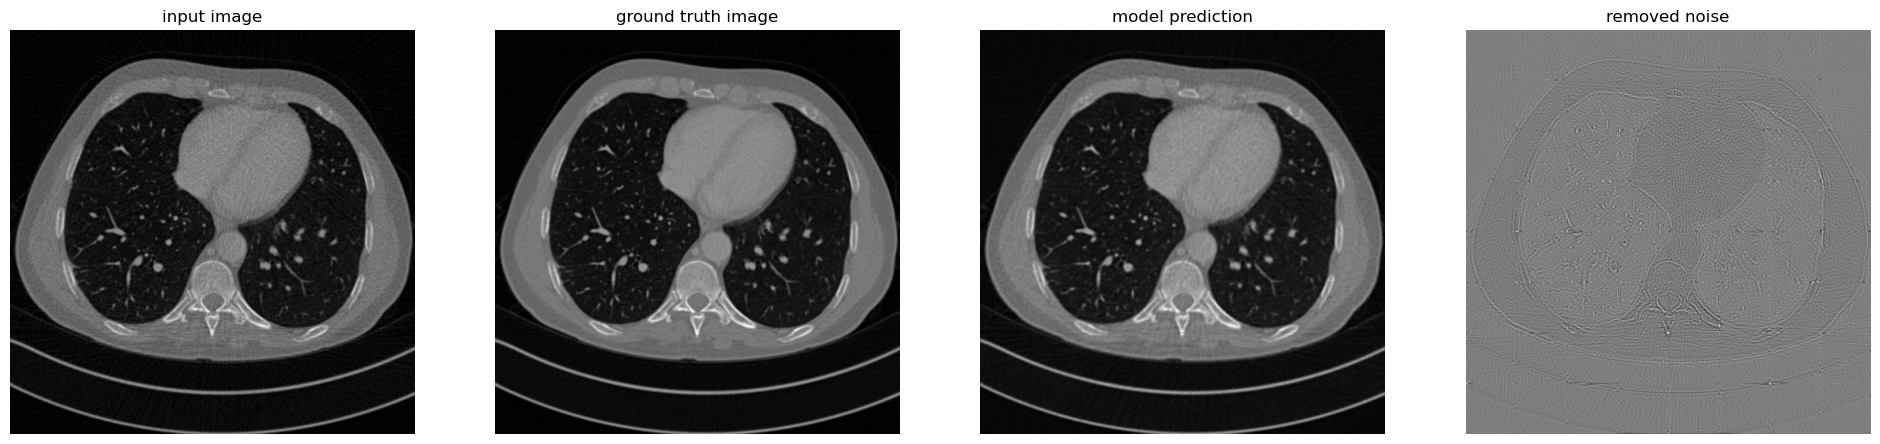

this image has start patches :  128
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (512, 512, 1)
PSNR of reconsturcted image :  37.5909949682184
PSNR of noisy image :  35.94381337057423


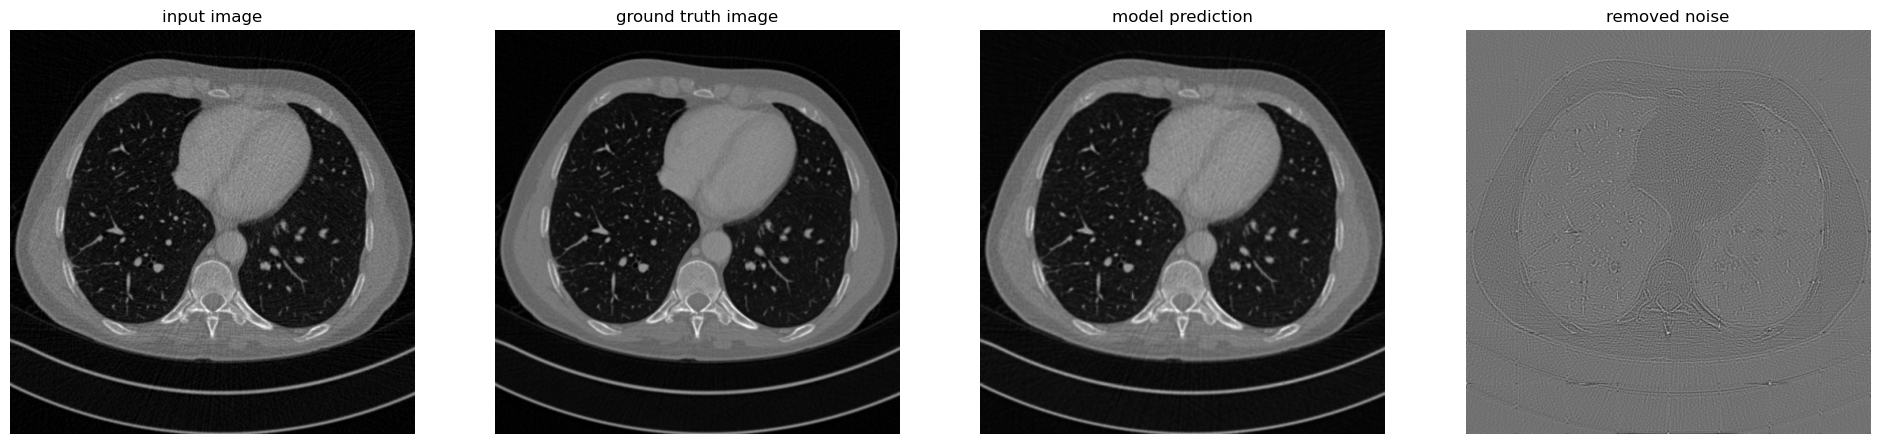

this image has start patches :  192
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (512, 512, 1)
PSNR of reconsturcted image :  37.53851618410408
PSNR of noisy image :  35.80295137061293


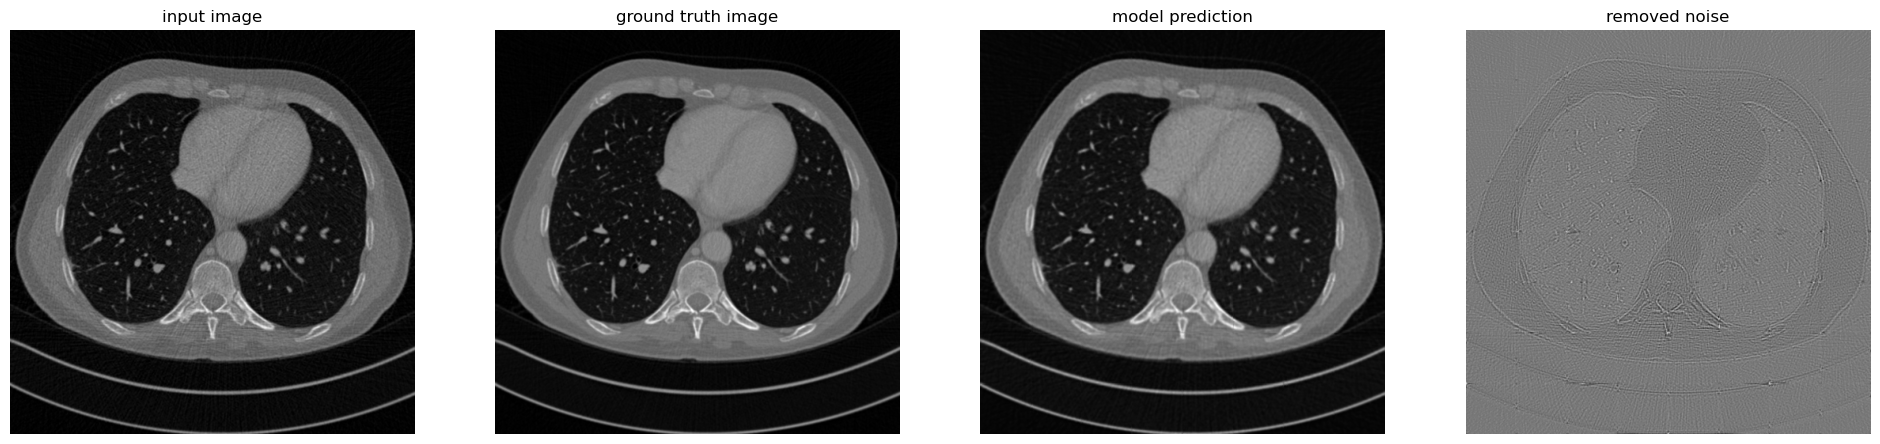

this image has start patches :  256
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (512, 512, 1)
PSNR of reconsturcted image :  37.73708284732471
PSNR of noisy image :  36.031714880289194


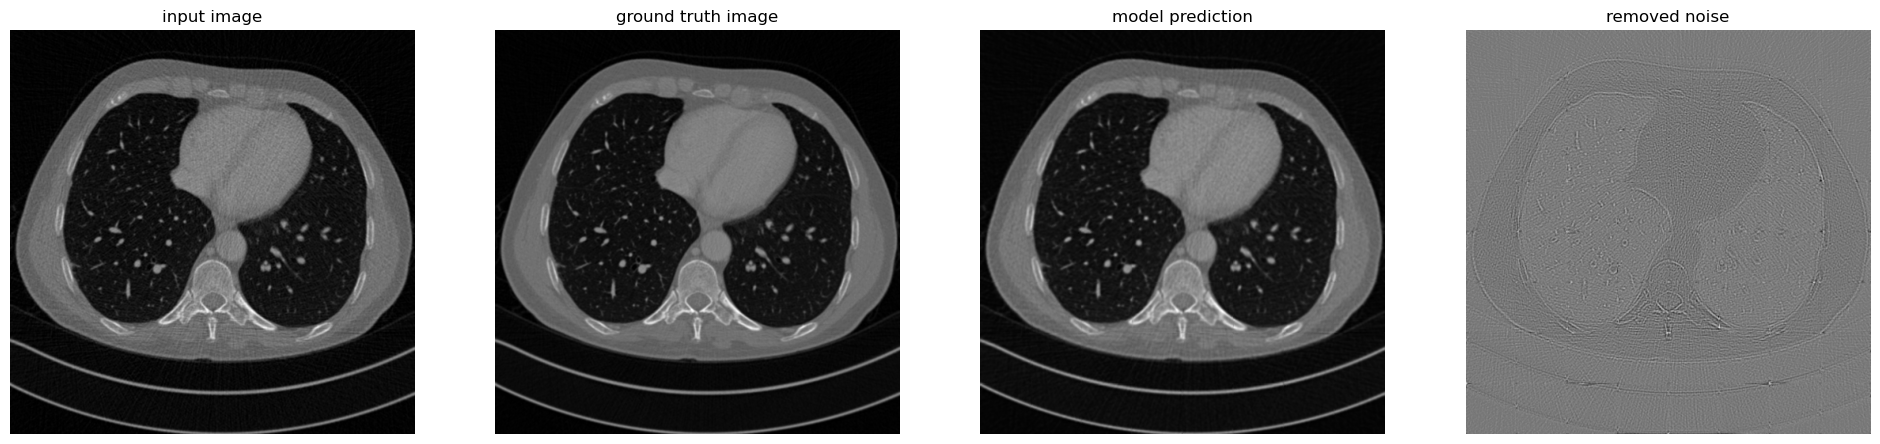

this image has start patches :  320
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (512, 512, 1)
PSNR of reconsturcted image :  37.82837900731865
PSNR of noisy image :  36.14461720214498


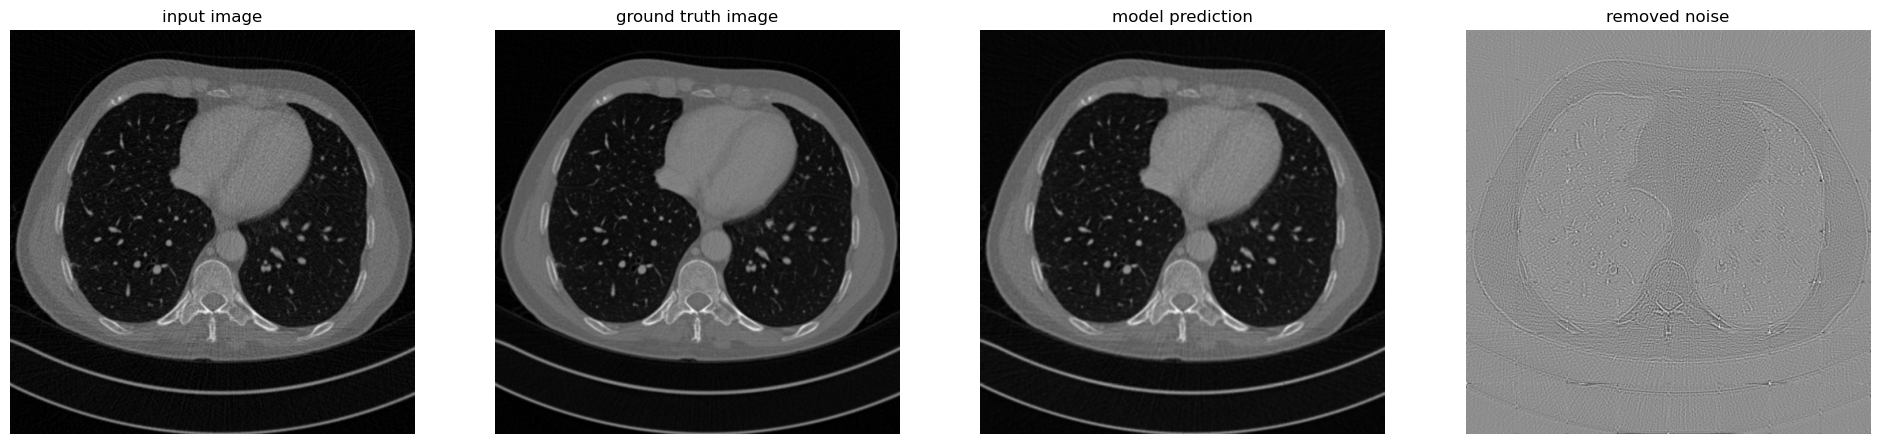

this image has start patches :  384
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (512, 512, 1)
PSNR of reconsturcted image :  37.69170672421892
PSNR of noisy image :  35.89484727398816


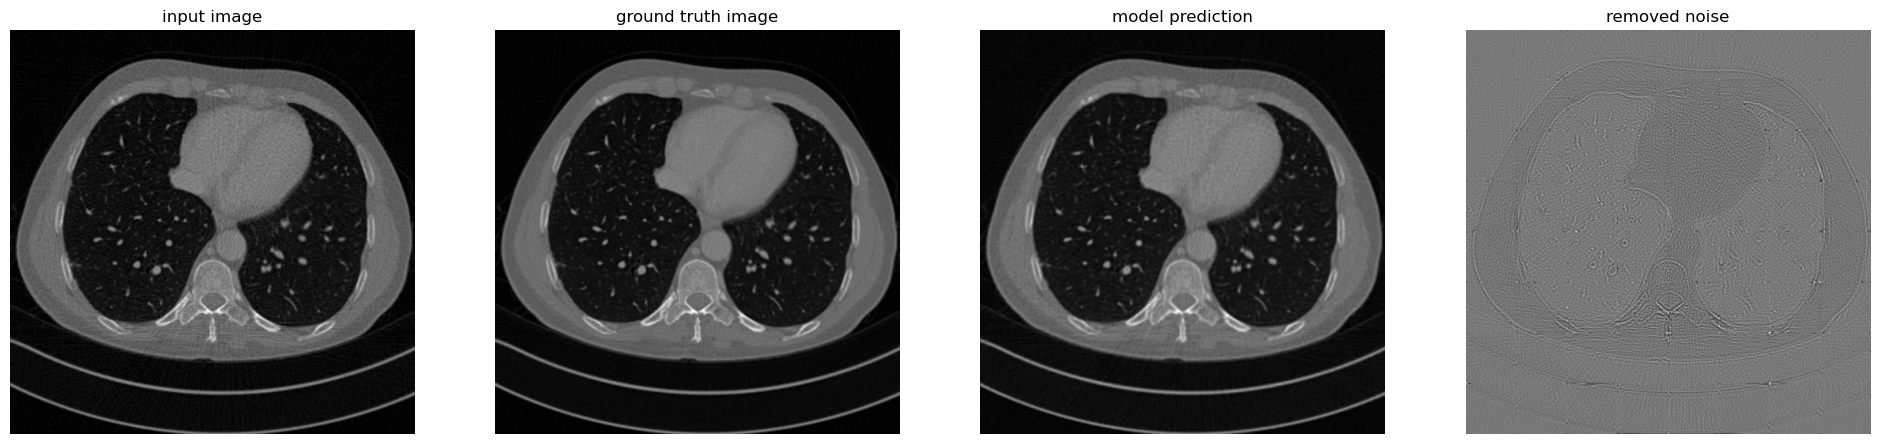

this image has start patches :  448
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (512, 512, 1)
PSNR of reconsturcted image :  37.95688408288062
PSNR of noisy image :  36.22792618702719


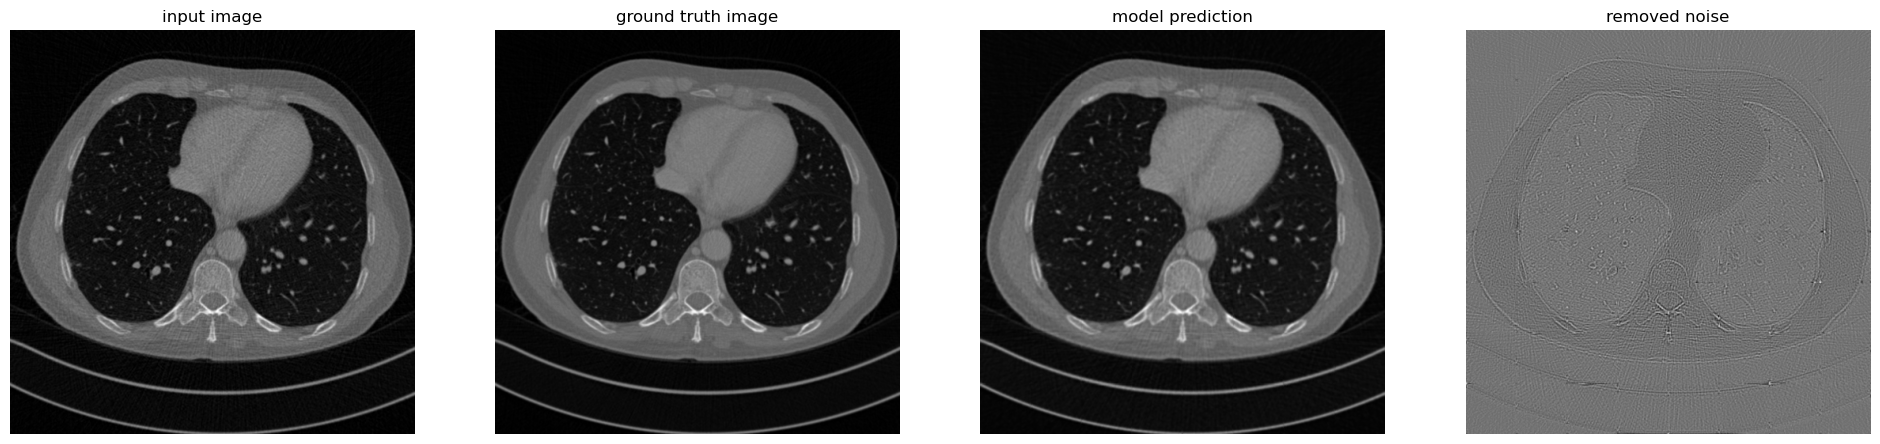

this image has start patches :  512
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (512, 512, 1)
PSNR of reconsturcted image :  38.05802278424228
PSNR of noisy image :  36.32200486139171


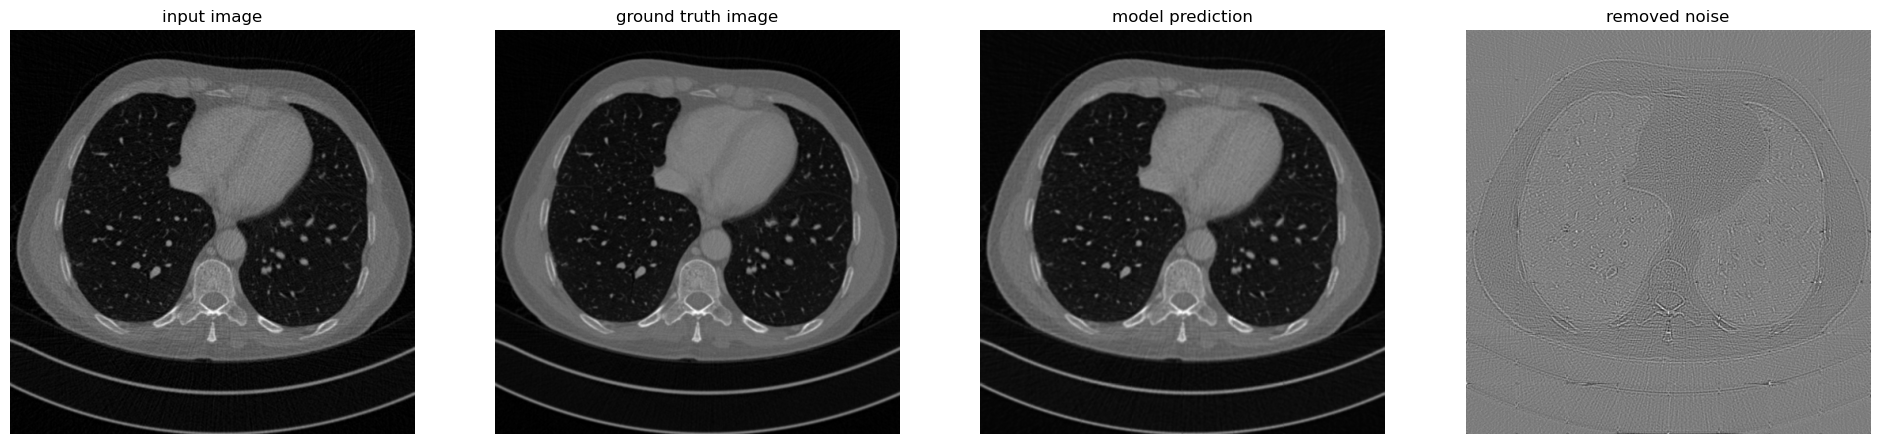

this image has start patches :  576
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (512, 512, 1)
PSNR of reconsturcted image :  37.86711640604
PSNR of noisy image :  36.09872754437181


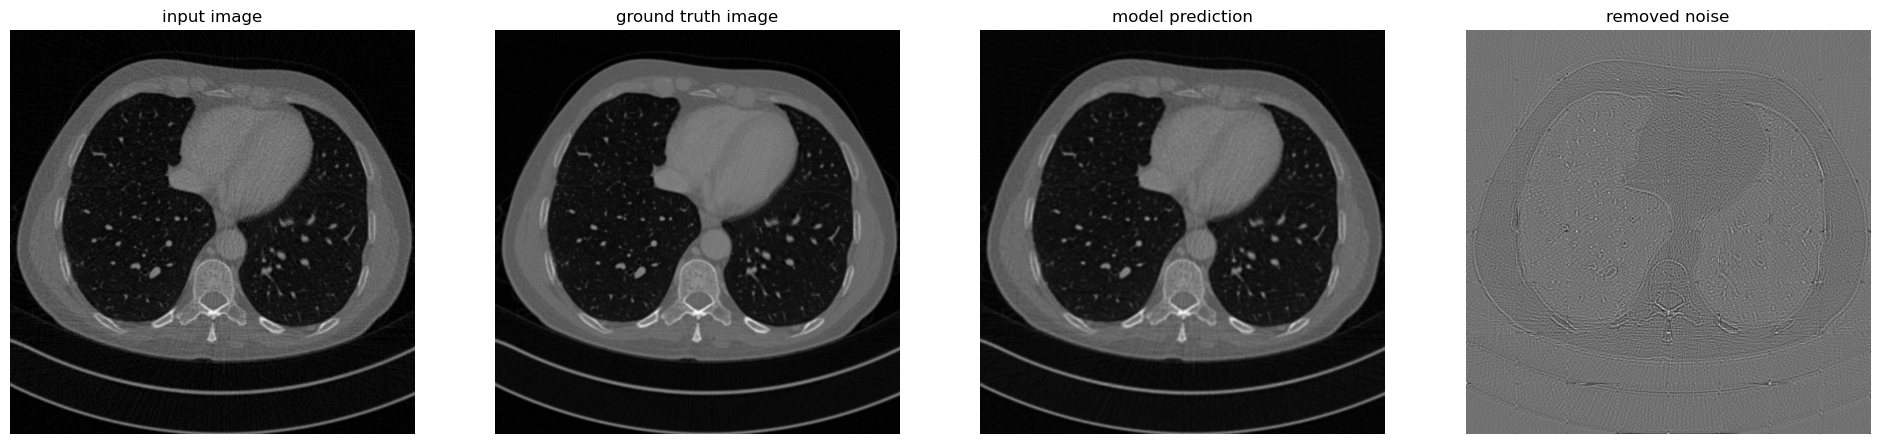

In [123]:

visualize_patches(predictions, noisy_images, ground_truth_images, 10)